# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [20]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/caro/Documentos/metodos/tp2/metnum-tp2
-- Configuring done
-- Generat

In [1]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/caro/Documentos/metodos/tp2/metnum-tp2/notebooks
Python 3.6.9


## Explorando los datos

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [3]:
c = df_train[:10000]
c = c.sample(frac=1)
c

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
9531,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6642,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8453,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8930,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7306,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6609,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4166,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [4]:
# Uso values para mandar todo a arrays de numpy

X = c[c.columns[1:]].values
y = c["label"].values.reshape(-1, 1)

X.shape, y.shape


((10000, 784), (10000, 1))

### Conjunto de development

In [5]:
%%time
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import time
def do_pca(upper_bound, start, steps, x_train, x_labels, x_val, y_val):
    i = start
    alpha = np.empty(0, dtype='d')
    ac = np.empty(0, dtype='d')
    rc = np.empty(0, dtype='d')
    tm = np.empty(0, dtype='d')
    pc = np.empty(0, dtype='d')
    while i < (upper_bound + 1):
      pca = metnum.PCA(i)
      pca.fit(x_train)
      X_train_transformed = pca.transform(x_train)
      X_transformed = pca.transform(x_val)
    
      start = time.time()
      knn = metnum.KNNClassifier(5)  
      knn.fit(X_train_transformed, x_labels)
      y_pred = knn.predict(X_transformed)
      end = time.time()
      ac_score = accuracy_score(y_val, y_pred)
      rc_score = recall_score(y_val, y_pred, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')
      prec_score = precision_score(y_val, y_pred, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')
      ac = np.append(ac, ac_score)
      rc = np.append(rc, rc_score)
      pc = np.append(pc, prec_score)
      alpha = np.append(alpha, i)
      tm = np.append(tm, (end-start)/60)
      i = i + steps
    return alpha, ac, rc, tm, pc
    

CPU times: user 259 ms, sys: 47.8 ms, total: 307 ms
Wall time: 306 ms


In [6]:
%%time
from sklearn.model_selection import StratifiedKFold, GroupKFold
z = y.flatten()
splits = 5
group_kfold = StratifiedKFold(n_splits=splits)

start = 25
steps = 3
upper_bound_alpha = 76
vectors_size = 52//3 + 1
ks = np.zeros(vectors_size)
ac = np.zeros(vectors_size)
rc = np.zeros(vectors_size)
tm = np.zeros(vectors_size)
pc = np.zeros(vectors_size)

for train_index, test_index in group_kfold.split(X, z):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ks_i, ac_i, rc_i, tm_i, pc_i = do_pca(upper_bound_alpha,start,steps,X_train, y_train, X_test, y_test)
    ks = ks + ks_i
    ac = ac + ac_i
    rc = rc + rc_i
    tm = tm + tm_i
    pc = pc + pc_i
    
ks_m = ks/splits
ac_m = ac/splits
rc_m = rc/splits
tm_m = tm/splits
pc_m = pc/splits

print(ac_m)

/home/caro/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8674 0.8669 0.8676 0.8682 0.8693 0.8695 0.8689 0.8678 0.8683 0.8675
 0.8671 0.867  0.8652 0.8652 0.8647 0.8644 0.864  0.8645]
CPU times: user 9min 1s, sys: 6.45 s, total: 9min 7s
Wall time: 9min 7s


In [7]:
print(tm_m)

[0.03580953 0.03673012 0.03688891 0.03877609 0.03808948 0.04198128
 0.04227151 0.04212782 0.04263728 0.04174547 0.04522931 0.04943634
 0.05154039 0.0507784  0.05254598 0.04765862 0.05094803 0.05350434]


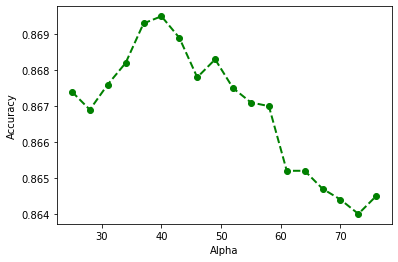

In [12]:
import matplotlib.pyplot as plt
plt.plot(ks_m, ac_m, color='green', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Alpha')
plt.savefig('10000accuracyMejorRangoAlphaK5.png')

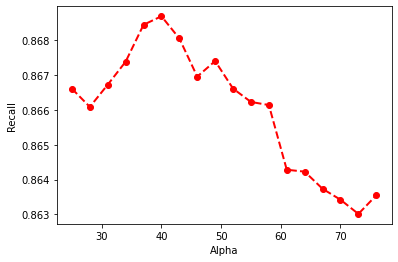

In [13]:
plt.plot(ks_m, rc_m, color='red', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Recall')
plt.xlabel('Alpha')
plt.savefig('10000recallMejorRangoAlphaK5.png')

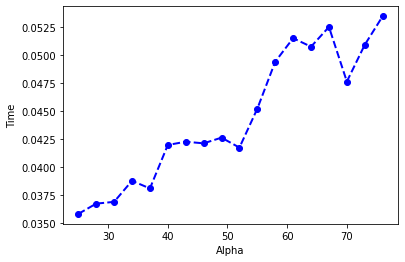

In [14]:
plt.plot(ks_m, tm_m, color='blue', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Time')
plt.xlabel('Alpha')
plt.savefig('10000timeMejorRangoAlphaK5.png')

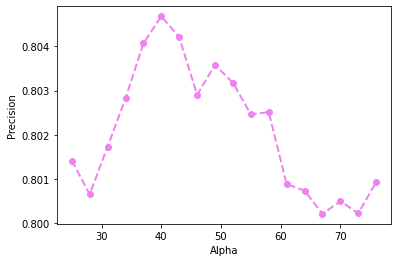

In [15]:
plt.plot(ks_m, pc_m, color='violet', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Precision')
plt.xlabel('Alpha')
plt.savefig('10000precisionMejorRangoAlphaK5.png')